# Problem Set 8

### name: Ruorong Qi

### Problem 1: Use regression to fit data to a polynomial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.io
import seaborn as sns

#### Problem 1.1 Write code to generate data from a polynomial with added noise.

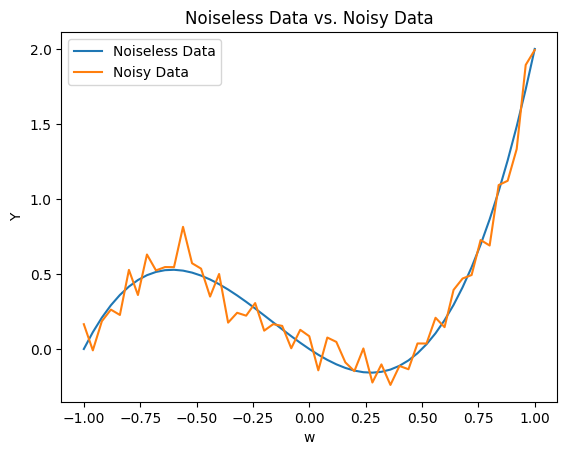

In [200]:
# Generate a one-dimensional array w (length N=51) that spans the range -1 to 1.
w = np.linspace(-1, 1, 51)

# Generate Y_noiseless (length 51) such that Y_noiseless = 2w3 + w2 - w. 
# Note: these coefficients[2, 1, -1] are θ.
Y_noiseless = 2 * w**3 + w**2 - w

# Generate a one-dimensional array of noise (length 51) where each entry is drawn 
# from a normal distribution with mean 0 and standard deviation 0.1.
noise = np.random.normal(0, 0.1, 51)

# Generate the variable Y which is equal to Y_noiseless + noise.
Y = Y_noiseless + noise

# Make a plot of Y_noiseless vs w, and also Y vs w.
plt.plot(w, Y_noiseless, label='Noiseless Data')
plt.plot(w, Y, label='Noisy Data')
plt.title('Noiseless Data vs. Noisy Data')
plt.xlabel('w')
plt.ylabel('Y')
plt.legend()
plt.show()


#### Problem 1.2: construct the "design matrix" X

In [201]:
# Here, the true model that we used to generate the noiseless data is y_noiseless = 2w^3 + w^2 - w.
# where the coefficients are [2, 1, -1]. In regression, the design matrix X, each column represent
# a feature of y, and each row represent a data point. Therefore, the design matrix X is a 51x3 matrix.
# By stacking w^3, w^2, and w together, we get the design matrix X.

X = np.column_stack([w**3, w**2, w])
X.shape

(51, 3)

#### Problem 1.3: Fit GLM with sklearn
answer: The estimate for $\theta$ is  [2.12494369  0.96158017 -1.08725542]. The estimate gets better (closer to true value by model: [2, 1, -1]) when I decrease the amount of noise added


In [202]:
# noise with mean 0 and standard deviation 0.1
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, Y)
print("noise with mean 0 and std 0.1:", reg.coef_)

# decrease the amount of noise
# noise with mean 0 and standard deviation 0.01
noise = np.random.normal(0, 0.01, 51)
Y = Y_noiseless + noise
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, Y)
print("noise with mean 0 and std 0.01:", reg.coef_)

# return to the original noise
noise = np.random.normal(0, 0.1, 51)
Y = Y_noiseless + noise

noise with mean 0 and std 0.1: [ 1.94554971  0.98095129 -0.97338712]
noise with mean 0 and std 0.01: [ 1.98250934  1.00107514 -0.99222736]


#### Problem 1.4: Solve for $\theta$ using the closed-form solution of GLM
answer: GLM fit with small amount of noise gave the best estimate because it keeps Y close to the true polynomial. The estimate generated by closed-form solution and GLM fit is similar, but upon multiple test run, LinearRegression() is slightly more stable in its estimation. 

In [203]:
# X^T * X * θ = X^T * Y
# θ = (X^T * X)^-1 * X^T * Y
# except for using invert_matrix(X.transpose * X) * X.transpose * Y,
# np.linalg.inv() can be used to calculate the inverse of a matrix here

theta_closed_form = np.linalg.inv(X.T @ X) @ X.T @ Y 
print("Estimated θ with closed-form solution:", theta_closed_form)

Estimated θ with closed-form solution: [ 1.94507612  1.03456391 -0.95426161]


### Problem 2: Implement regularization and cross-validation

In [204]:
loaded_data = scipy.io.loadmat('RGCdata.mat') 
Stim = loaded_data['Stim'].flatten()
SpCounts = loaded_data['SpCounts']

# Stim is a 1d-array of the stimulus intensity, which can take only one of two values. 
# SpCounts is a 2d-array of the spike counts from 4 neurons. Use only the spike counts 
# from the first neuron and discard the other three neurons.
print(Stim.shape)
print(SpCounts.shape)

# The first neuron's spike counts
SpCounts = SpCounts[:, 0]
print(SpCounts.shape)

(144051,)
(144051, 4)
(144051,)


#### Problem 2.1: Plot first 100 values of Stim and SpCounts

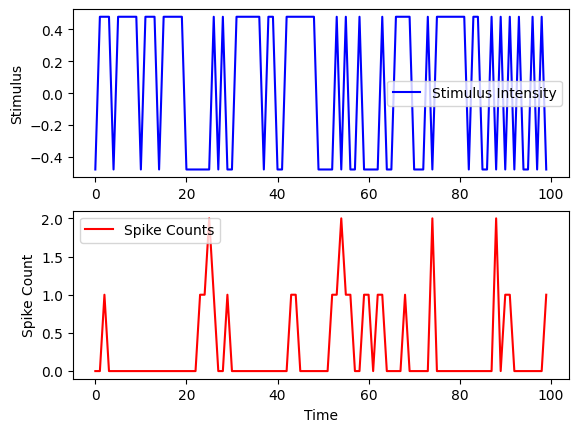

In [205]:
# Create 2 plots for first 100 stim and first 100 spike counts of the first neuron
plt.subplot(2, 1, 1)
plt.plot(Stim[:100], label="Stimulus Intensity", color='b')
plt.ylabel("Stimulus")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(SpCounts[:100], label="Spike Counts", color='r')
plt.xlabel("Time")
plt.ylabel("Spike Count")
plt.legend()

#### Problem 2.2: Set up design matrix x

In [206]:
d = 25 # lag duration
padded_stim = np.concatenate([np.zeros(d - 1), Stim]) # pad the stimulus with d-1 zeros at the beginning

# Construct a design matrix where rows are timepoint, and column is the frames of stimulus
# First initialize the matrix X with zeros
# Then, for each time point t, set the t-th row of X to be the d frames of the stimulus
T = len(Stim)
X = np.zeros((T, d))
for t in range(T):
    X[t] = padded_stim[t:t + d]
print(X.shape)

(144051, 25)


In [207]:
len(Stim)

144051

In [208]:
SpCounts.shape

(144051,)

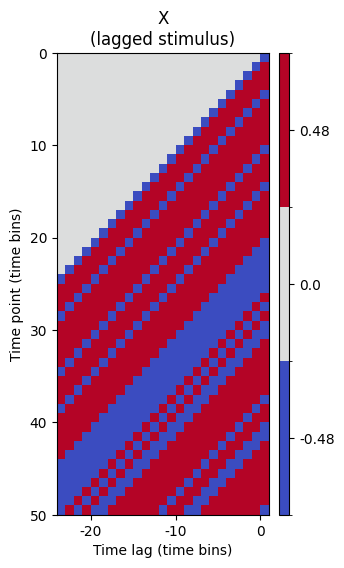

In [209]:
nt = 50
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax_x = plt.subplots(figsize=(3, 6),)
norm = BoundaryNorm([-1, -.2, .2, 1], 256)
imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)

ax_x.set(
title="X\n(lagged stimulus)",
xlabel="Time lag (time bins)",
xticks=[4, 14, 24],
xticklabels=['-20', '-10', '0'],
ylabel="Time point (time bins)",
)
plt.setp(ax_x.spines.values(), visible=True)

divx = make_axes_locatable(ax_x)
caxx = divx.append_axes("right", size="5%", pad=0.1)
cbarx = f.colorbar(imx, cax=caxx)
cbarx.set_ticks([-.6, 0, .6])
cbarx.set_ticklabels(np.sort(np.unique(X)))

ax_x.invert_yaxis()
plt.show()

#### Problem 2.3: calculate $\theta$ with $\theta = (X^T * X + \beta * I)^-1 * X^T * Y$ with regularization term $\beta$

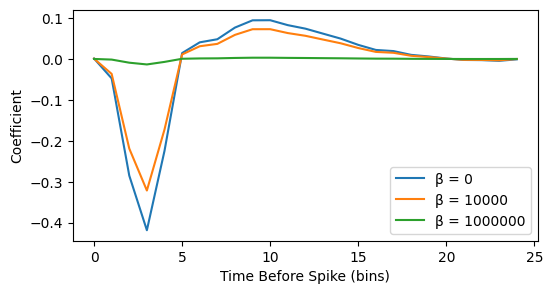

In [216]:
beta_values = [0, 10000, 1000000]
theta_results = []
for beta in beta_values:
    theta = np.linalg.inv(X.T @ X + beta * np.eye(25)) @ X.T @ SpCounts
    theta_results.append(theta)

# Since our X matrix is designed such that the first column correspond to the
# stimulus at time t-24, the the last column correspond to the stimulus at time t,
# therefore, to reconstruct the figure that plot the coefficient vs. time before spike
# we need to reverse the theta array
theta_results = [theta[::-1] for theta in theta_results]

plt.figure(figsize=(6, 3))
for i, beta in enumerate(beta_values):
    plt.plot(theta_results[i], label=f"β = {beta}")

plt.xlabel("Time Before Spike (bins)")
plt.ylabel("Coefficient")
plt.legend()
plt.show()

#### Problem 2.4: Describe Problem 2.3
answer: as $\beta$ gets larger, the coefficient changes become more stable before spike. This is likely due to $\beta$'s role in regularization. When $\beta=0$, the model fit the training data exactly and may lead to overfitting, when $\beta=1e6$, the regularization is too strong where coefficient approach zero. Since the neuroal spike response is mainly nfluenced by recent stimuli, distant past stimuli have less impact, so coefficients tend to shrink to zero over time. If we increased history from 25 to 100 samples, even more distant coefficients would be near zero. 

#### Problem 2.5: Explain in words / pseudo-code to implement cross-validation for the calculation you did in Problem 2.3. 
answer: 
1. Split data (X and SpCounts) into training set, testing set, and validation set: The training and validation sets are used for training and model selection, while the test set is reserved for final evaluation. The training set is used to fit the model, and the validation set is used to tune the model's hyperparameters.
2. Train the model on the training set: For example, use Ridge regression with different values of  𝛽 to train the model using the stimulus data (X) and spike counts (SpCounts) from the training set.
3. Evaluate the model on the validation set: After training the model, feed the model with 𝑋_validation to get predicted spike counts (𝑌_pred) and compare them with the true spike counts 𝑌_validation from the validation set.
4. Compute the performance metric: Use a performance metric, such as Mean Squared Error (MSE), to compare the model's predictions with the true outcomes in the validation set.
5. Iterate over the dataset using a cross-validation method: Repeat steps 2-4 multiple times using cross-validation (splitting the data into different training, validation, and testing subsets to ensure a robust evaluation of the model's performance).